In [2]:
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import pickle
import pandas as pd
import numpy as np
from psm_causal_effects import psm_causal_effects

# read data
with open('data.dat') as f:
    data, subjects = pickle.load(f)
f.close()

# adding subject ids
for i in range(len(data)):
    data[i]['subject'] = pd.Series(np.repeat(subjects[i],data[i].shape[0],axis=0), index=data[i].index, dtype=str)

del subjects

# concatenatig into a single dataframe
data_all = pd.concat(data, axis=0)
data_all = data_all.reset_index(drop=True)

# keeping only relevant variables
data_all = data_all[['subject','mood','quality','mood_prev','quality_prev','stress_prev','act_prev','daytype','mean_temp','dow']]

# removing nan rows
data_all = data_all.dropna()
data_all = data_all.reset_index(drop=True)

# load assessments
with open('../CS120/Assessment/assessment.dat') as f:
    ass = pickle.load(f)
f.close()

In [3]:
# calculating personal model parameters

betas_m2s = np.zeros([len(data),2])
betas_s2m = np.zeros([len(data),2])
for iSubj in range(len(data)):
    if data[iSubj].shape[0] ==0:
        betas_m2s[iSubj, :] = np.array([np.nan, np.nan])
        betas_s2m[iSubj, :] = np.array([np.nan, np.nan])
    else:
        md = smf.glm('quality ~ mood_prev', data[iSubj])
        mdf = md.fit()
        betas_m2s[iSubj, :] = mdf.params
        md = smf.glm('mood ~ quality', data[iSubj])
        mdf = md.fit()
        betas_s2m[iSubj, :] = mdf.params

                 Generalized Linear Model Regression Results                  
Dep. Variable:                quality   No. Observations:                 7079
Model:                            GLM   Df Residuals:                     7077
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                   2.39680807433
Method:                          IRLS   Log-Likelihood:                -13138.
Date:                Wed, 15 Mar 2017   Deviance:                       16962.
Time:                        15:11:41   Pearson chi2:                 1.70e+04
No. Iterations:                     4                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.3074      0.066     19.895      0.000         1.179     1.436
mood_prev      0.6299      0.012     50.469      0.0

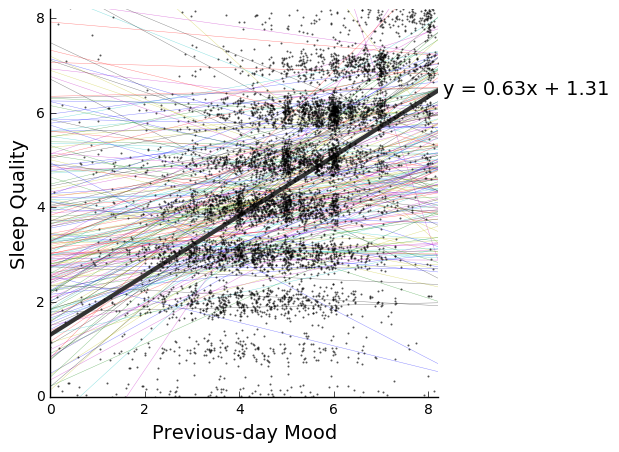

In [47]:
# global + personal

md = smf.glm('quality ~ mood_prev', data_all)
mdf = md.fit()
print mdf.summary()

plt.figure(figsize=[5,5])
for iSubj in range(len(data)):
    plt.plot([0,8.2], [betas_m2s[iSubj, 0],betas_m2s[iSubj,0]+betas_m2s[iSubj,1]*8.2], linewidth=.3, alpha=.5)
plt.plot([0,8.2], [mdf.params[0],mdf.params[0]+mdf.params[1]*8.2], color=(.2, .2,.2), linewidth=3, alpha=1)
plt.plot(data_all['mood_prev']+0.075*np.random.randn(data_all.shape[0]),data_all['quality']+0.2*np.random.randn(data_all.shape[0]),'.',markersize=2,\
        color=(0,0,0),alpha=.5)
plt.xlabel('Previous-day Mood',fontsize=14)
plt.ylabel('Sleep Quality',fontsize=14)
plt.xlim([0,8.2])
plt.ylim([0,8.2])

ax = plt.gca()
ax.spines['left'].set_position('zero')
# turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()
# set the y-spine
ax.spines['bottom'].set_position('zero')
# turn off the top spine/ticks
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()

plt.xticks(np.arange(0,9,2));
plt.yticks(np.arange(0,9,2));

plt.text(8.3,6.4,'y = {:.2}x + {:.3}'.format(mdf.params[1],mdf.params[0]),fontsize=14)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                   mood   No. Observations:                 7079
Model:                            GLM   Df Residuals:                     7077
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                   1.39467201826
Method:                          IRLS   Log-Likelihood:                -11221.
Date:                Wed, 15 Mar 2017   Deviance:                       9870.1
Time:                        15:11:27   Pearson chi2:                 9.87e+03
No. Iterations:                     4                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.8717      0.038     76.297      0.000         2.798     2.945
quality        0.4876      0.008     62.710      0.0

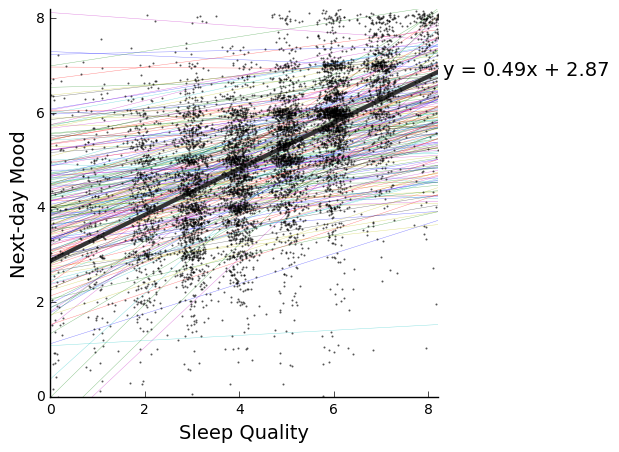

In [46]:
# global + personal

md = smf.glm('mood ~ quality', data_all)
mdf = md.fit()
print mdf.summary()

plt.figure(figsize=[5,5])
for iSubj in range(len(data)):
    plt.plot([0,8.2], [betas_s2m[iSubj, 0],betas_s2m[iSubj,0]+betas_s2m[iSubj,1]*8.2], linewidth=.3, alpha=.5)
plt.plot([0,8.2], [mdf.params[0],mdf.params[0]+mdf.params[1]*8.2], color=(.2,.2,.2), linewidth=3)
plt.plot(data_all['quality']+0.2*np.random.randn(data_all.shape[0]),data_all['mood']+0.075*np.random.randn(data_all.shape[0]),'.',markersize=2,\
        color=(0,0,0),alpha=.5)
plt.xlabel('Sleep Quality',fontsize=14)
plt.ylabel('Next-day Mood',fontsize=14)
plt.xlim([0,8.2])
plt.ylim([0,8.2])

ax = plt.gca()
ax.spines['left'].set_position('zero')
# turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()
# set the y-spine
ax.spines['bottom'].set_position('zero')
# turn off the top spine/ticks
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()

plt.xticks(np.arange(0,9,2));
plt.yticks(np.arange(0,9,2));

plt.text(8.3,6.8,'y = {:.2}x + {:.3}'.format(mdf.params[1],mdf.params[0]),fontsize=14)


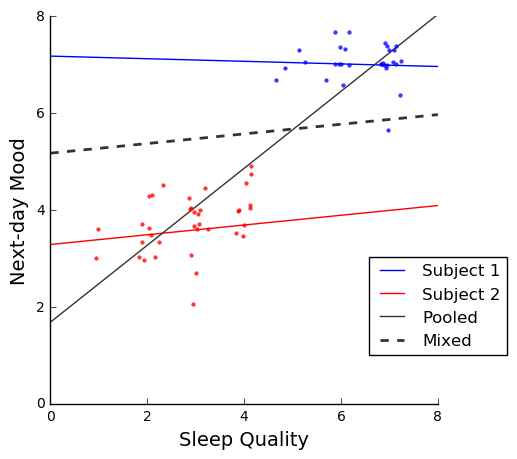

In [20]:
from psm_causal_effects import psm_causal_effects
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(seed=1)

noise_amp_mood = 0.05#0.075
noise_amp_quality = 0.15#0.2

ind1 = 49#6
ind2 = 149#100

# removing nan rows
data1 = data[ind1].dropna()
data1 = data1.reset_index(drop=True)
data2 = data[ind2].dropna()
data2 = data2.reset_index(drop=True)

plt.figure(figsize=[5,5])
plt.plot([0,8], [betas_s2m[ind1, 0]+betas_s2m[ind1,1]*3,betas_s2m[ind1,0]+betas_s2m[ind1,1]*8], linewidth=1, alpha=1, color=(0,0,1), linestyle='-')
plt.plot([0,8], [betas_s2m[ind2, 0]+betas_s2m[ind2,1]*1,betas_s2m[ind2,0]+betas_s2m[ind2,1]*5], linewidth=1, alpha=1, color=(1,0,0), linestyle='-')

data_p  = pd.concat([data1, data2],axis=0)
data_p = data_p[['subject','mood','quality']]

#pooled regression
md = smf.glm('mood ~ quality', data_p)
mdf = md.fit()
plt.plot([0,8], [mdf.params[0],mdf.params[0]+mdf.params[1]*8], color=(.2,.2,.2), linewidth=1, linestyle='-')

#mixed linear models regression
md = smf.mixedlm('mood ~ quality', data_p, groups=data_p['subject'], re_formula="~quality")
mdf = md.fit() 
plt.plot([0,8], [mdf.params[0],mdf.params[0]+mdf.params[1]*8], color=(.2,.2,.2), linewidth=2, linestyle='--')

#psm
# score1, ind_t1, ind_c1 = psm_causal_effects(treatment=data1['quality'], outcome=data1['mood'], confound=data1[['mood_prev','stress_prev','daytype','dow','act_prev','quality_prev','mean_temp']], scorefun='replacement', output='difference', return_indices=True)
# score2, ind_t2, ind_c2 = psm_causal_effects(treatment=data2['quality'], outcome=data2['mood'], confound=data2[['mood_prev','stress_prev','daytype','dow','act_prev','quality_prev','mean_temp']], scorefun='replacement', output='difference', return_indices=True)

plt.xlabel('Sleep Quality', fontsize=14)
plt.ylabel('Next-day Mood', fontsize=14)
plt.xlim([0,8])
plt.ylim([0,8])

plt.legend(['Subject 1','Subject 2','Pooled','Mixed'],bbox_to_anchor=(1.2, .4))

#noise vectors
n_quality_1 = noise_amp_quality*np.random.randn(data1.shape[0])
n_quality_2 = noise_amp_quality*np.random.randn(data2.shape[0])
n_mood_1 = noise_amp_mood*np.random.randn(data1.shape[0])
n_mood_2 = noise_amp_mood*np.random.randn(data2.shape[0])

plt.plot(data1['quality']+n_quality_1,data1['mood']+n_mood_1,'.',markersize=5,\
        markeredgecolor =(0,0,1),alpha=.75,markerfacecolor=(0,0,1))
# plt.plot(data1['quality'][ind_t1]+n_quality_1,data1['mood'][ind_t1]+n_mood_1,'o',markersize=5,\
#         markeredgecolor =(0,0,1),alpha=.75,markerfacecolor=(1,1,1))
# plt.plot(data1['quality'][ind_c1]+n_quality_1,data1['mood'][ind_c1]+n_mood_1,'x',markersize=5,\
#         markeredgecolor =(0,0,1),alpha=.75,markerfacecolor=(0,0,1))
# plt.plot([7,7.5],[np.mean(data1['mood'][ind_t1]),np.mean(data1['mood'][ind_t1])],color=(0,0,1),linewidth=3)
# plt.plot([5,5.5],[np.mean(data1['mood'][ind_c1]),np.mean(data1['mood'][ind_c1])],color=(0,0,1),linewidth=3)

plt.plot(data2['quality']+n_quality_2,data2['mood']+n_mood_2,'.',markersize=5,\
        markeredgecolor =(1,0,0),alpha=.75,markerfacecolor=(1,0,0))
# plt.plot(data2['quality'][ind_t2]+n_quality_2,data2['mood'][ind_t2]+n_mood_2,'o',markersize=5,\
#         markeredgecolor =(1,0,0),alpha=.75,markerfacecolor=(1,1,1))
# plt.plot(data2['quality'][ind_c2]+n_quality_2,data2['mood'][ind_c2]+n_mood_2,'x',markersize=5,\
#         markeredgecolor =(1,0,0),alpha=.75,markerfacecolor=(1,0,0))
# plt.plot([4,4.5],[np.mean(data2['mood'][ind_t2]),np.mean(data2['mood'][ind_t2])],color=(1,0,0),linewidth=3)
# plt.plot([2.5,3],[np.mean(data2['mood'][ind_c2]),np.mean(data2['mood'][ind_c2])],color=(1,0,0),linewidth=3)

plt.ylim([0,8])
plt.xlim([0,8])

ax = plt.gca()
ax.spines['left'].set_position('zero')

# turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()

# set the y-spine
ax.spines['bottom'].set_position('zero')

# turn off the top spine/ticks
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()

plt.xticks(np.arange(0,9,2));
plt.yticks(np.arange(0,9,2));



# print score1,score2


(-0.2608202654786535, -0.22803390145593702)

In [40]:
[data1['quality'][ind_t1].T+n_quality_1, data1['quality'][ind_c1].T+n_quality_1]

[0     6.678378
 1     7.099056
 2     6.676675
 9     6.661835
 10    6.847383
 12    7.009743
 13    7.099598
 15    7.080837
 19    6.912213
 20    6.851378
 22    6.961649
 23    7.183126
 24    7.075649
 25    7.171559
 26    7.075250
 27    6.947845
 Name: quality, dtype: float64, 8     5.678378
 6     5.099056
 11    5.676675
 11    5.661835
 11    5.847383
 21    6.009743
 4     5.099598
 4     5.080837
 3     4.912213
 21    5.851378
 29    5.961649
 11    6.183126
 11    6.075649
 3     5.171559
 4     5.075250
 21    5.947845
 Name: quality, dtype: float64]